### Часть 2

Посчитать GINI, KS, построить ROC-AUC, распределения для двух классов.

In [166]:
%%capture
%pip install -r requirements.txt

In [167]:
import pandas as pd
import numpy as np
import seaborn as sns
from scipy.integrate import simpson
from scipy.stats import ecdf, kstest
from sklearn.metrics import roc_curve, roc_auc_score
from matplotlib import pyplot as plt
from operator import itemgetter
%matplotlib inline

In [168]:
df = pd.read_excel("Тестовое задание.xlsx")
df.columns=["PD", "Status"]

In [169]:
df.head()

,PD,Status
0,0.0008,Хороший
1,0.0009,Хороший
2,0.0010,Хороший
3,0.0010,Хороший
4,0.0010,Хороший


Проверка null значений

In [170]:
df.isna().sum()

PD        0
Status    0
dtype: int64

In [171]:
label_dict = {
    "Дефолт" : 1, # т.к. предсказываем вероятность дефолта, положительный класс - дефолт
    "Хороший" : 0, 
}

In [172]:
df["Label"] = df['Status'].map(label_dict)

In [173]:
preds = df["PD"]
targets = df["Label"]
preds_with_targets = zip(preds, targets)
preds_with_targets = np.array(sorted(preds_with_targets, key=itemgetter(0), reverse=True))


Вычисление Gini

In [174]:
cumulative_targets = np.cumsum(preds_with_targets[:, 1]) / np.sum(targets)
cumulative_targets_perfect = np.cumsum(sorted(targets, reverse=True)) / np.sum(targets)

In [175]:
def prepend_zero(a: np.array) -> np.array:
    return np.concat(([0], a))
    

In [176]:
x_values = np.linspace(0, 1, num=1 + len(targets))
y_targets = prepend_zero(cumulative_targets)
y_targets_perfect = prepend_zero(cumulative_targets_perfect)

In [177]:
# interp1d deprecated в документации, вместо рекомендуют np.interp 
x_interp = np.linspace(0, 1, num=1000)
f1 = np.interp(x=x_interp, xp=x_values, fp=y_targets)
f2 = np.interp(x=x_interp, xp=x_values, fp=y_targets_perfect)

S_pred = simpson(y=f1, x=x_interp) - 0.5
S_actual = simpson(y=f2, x=x_interp) - 0.5

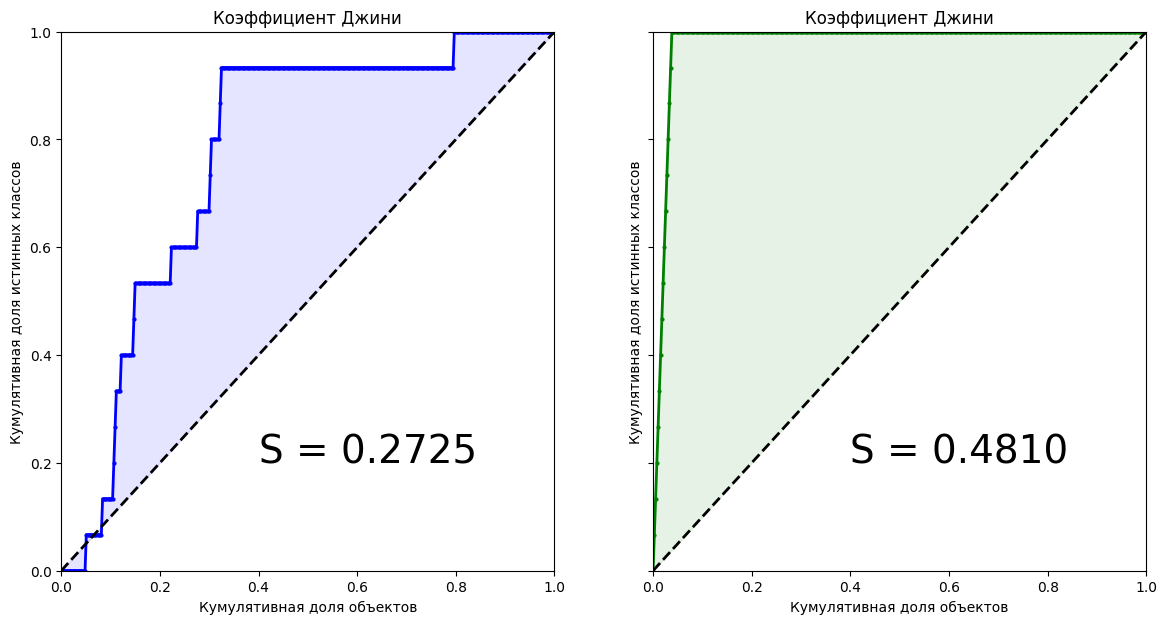

In [178]:
fig, ax = plt.subplots(nrows=1,ncols=2, sharey=True, figsize=(14, 7))
ax[0].plot(x_values, y_targets, lw = 2, color = 'blue', marker='o', markersize=2)
ax[0].fill_between(x_values, x_values, y_targets, color = 'blue', alpha=0.1)
ax[0].text(0.4,0.2,'S = {:0.4f}'.format(S_pred),fontsize = 28)
ax[1].plot(x_values, y_targets_perfect, lw = 2, color = 'green', marker='o', markersize=2)
ax[1].fill_between(x_values, x_values, y_targets_perfect, color = 'green', alpha=0.1)
ax[1].text(0.4,0.2,'S = {:0.4f}'.format(S_actual),fontsize = 28)

for i in range(2):
    ax[i].plot([0,1],[0,1],linestyle = '--',lw = 2,color = 'black')
    ax[i].set(title='Коэффициент Джини', xlabel='Кумулятивная доля объектов', 
              ylabel='Кумулятивная доля истинных классов', xlim=(0, 1), ylim=(0, 1))
plt.show()

In [179]:
gini_normalized = S_pred / S_actual
print(f"Нормализованный Gini: {gini_normalized:.2f}")

Нормализованный Gini: 0.57


Построение ROC кривой

In [180]:
fpr, tpr, t = roc_curve(targets, preds)
auc = roc_auc_score(targets, preds)

Text(0.4, 0.2, 'S = 0.7842')

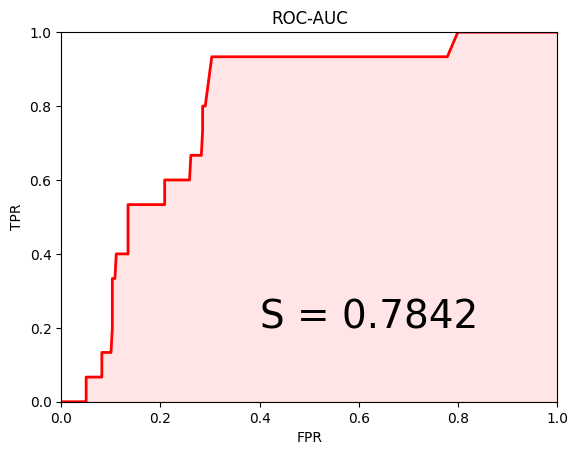

In [181]:
plt.plot(fpr, tpr, lw = 2, color = 'red')
plt.fill_between(fpr, tpr, color = 'red', alpha=0.1)
plt.title("ROC-AUC")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.text(0.4, 0.2, f"S = {auc:.4f}",fontsize = 28)

AUC = 0.7842. Проверим выполняется ли $ Gini_{normalized} = 2 * AUC - 1$

In [182]:
print(f"Разница: {abs(gini_normalized - (2*auc - 1))}")

Разница: 0.001772289705526453


Равенство выполняется с некоторой погрешностью

Построение распределений для классов клиентов

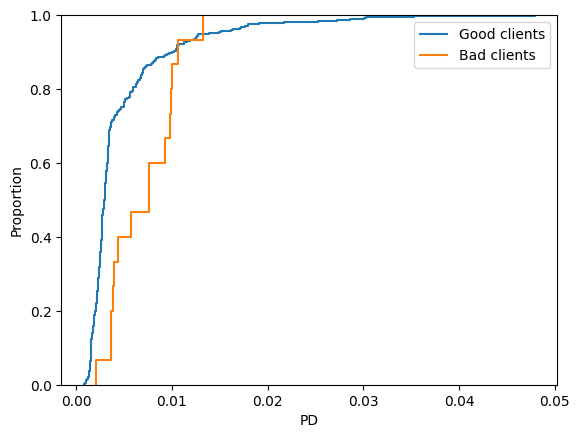

In [183]:
sns.ecdfplot(df[df["Label"] == 0], x="PD")
sns.ecdfplot(df[df["Label"] == 1], x="PD")
plt.legend(["Good clients", "Bad clients"])

Вычисление коэффициента KS (как максимальной разницы между графиками распределений)

In [184]:
good_clients = df[df["Label"] == 0]
bad_clients = df[df["Label"] == 1]

In [185]:
good_clients_ecdf = ecdf(good_clients["PD"]).cdf
bad_clients_ecdf = ecdf(bad_clients["PD"]).cdf

Интерполируем распределения, чтобы вычислить разницу между ними в одной точке. (Замечание: "плохих" клиентов всего 15 в сампле)

In [186]:
x_interp_ks = np.linspace(0, 0.05, 500) 
good_clients_interp = np.interp(x_interp_ks, xp=good_clients_ecdf.quantiles, fp=good_clients_ecdf.probabilities)
bad_clients_interp = np.interp(x_interp_ks, xp=bad_clients_ecdf.quantiles, fp=bad_clients_ecdf.probabilities)

In [187]:
ks_scipy = kstest(good_clients["PD"], bad_clients["PD"])

In [188]:
ks_diy = np.abs(good_clients_interp - bad_clients_interp).max()

In [189]:
print(f"KS как разница между интерполированными распределениями {ks_diy:.4f}\nKS от scipy: {ks_scipy.statistic:.4f}")

KS как разница между интерполированными распределениями 0.5077
KS от scipy: 0.6299
